<a href="https://www.kaggle.com/code/abhinandan0506/vgg19-lstm-svm-model?scriptVersionId=180374657" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Reshape, BatchNormalization, Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from math import floor

2024-05-29 07:05:02.510604: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 07:05:02.510727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 07:05:02.688278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Defining directories

In [2]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

# Hyperparameters

In [3]:
EPOCHS = 50
INIT_LR = 1e-3
decay_rate = 0.95
decay_step = 1
IMAGE_SIZE = [224, 224]

In [4]:
def Combined_model():
    # Input layer
    input_layer = Input(shape=(224, 224, 3))

    # Base VGG19 model as a feature extractor
    baseModel = VGG19(weights='imagenet', include_top=False, input_tensor=input_layer)

    # Freeze the layers of the VGG19 model
    for layer in baseModel.layers:
        layer.trainable = False

    x = baseModel.output

    # LSTM layer
    x = Reshape((49, 512))(x)
    x = LSTM(512, activation="relu", return_sequences=True, trainable=False)(x)
    x = BatchNormalization()(x)

    # Flatten output from LSTM
    x = Flatten()(x)

    # Output layer
    output = Dense(4, activation='softmax')(x)

    # Define the model
    model = Model(inputs=input_layer, outputs=output)

    opt = Adam(learning_rate=INIT_LR)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    
    return model

# Creating the model

In [5]:
model = Combined_model()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 49, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 49, 512)        │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 49, 512)        │         2,04

 Total params: 22,225,988 (84.79 MB)

 Trainable params: 101,380 (396.02 KB)

 Non-trainable params: 22,124,608 (84.40 MB)

# Load and preprocess data

In [7]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=(224, 224))

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(224, 224),
                                                                shuffle=False)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


# Data augmentation

In [8]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    return image, label

In [9]:
train_dataset_augmented = train_data.map(augment_image)

In [10]:
checkpoint = ModelCheckpoint(filepath='best_model.weights.h5', 
                             monitor='val_accuracy', 
                             mode='max', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=True)
earlystop = EarlyStopping(monitor='accuracy', 
                          min_delta=0, 
                          patience=15, 
                          verbose=1, 
                          mode='max')
lr_scheduler = LearningRateScheduler(lambda epoch: INIT_LR * pow(decay_rate, floor(epoch / decay_step)))

# Training the model

In [11]:
history = model.fit(train_dataset_augmented,
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_dataset_augmented),
                    validation_data=test_data,
                    callbacks=[checkpoint, earlystop, lr_scheduler])

Epoch 1/50
  1/179 ━━━━━━━━━━━━━━━━━━━━ 1:39:13 33s/step - accuracy: 0.2812 - loss: 1.9417

I0000 00:00:1716966355.749378      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716966355.780564      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.7366 - loss: 1.0222

W0000 00:00:1716966401.371233      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.82914, saving model to best_model.weights.h5


W0000 00:00:1716966436.458930      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/179 ━━━━━━━━━━━━━━━━━━━━ 114s 454ms/step - accuracy: 0.7370 - loss: 1.0210 - val_accuracy: 0.8291 - val_loss: 0.9102 - learning_rate: 0.0010
Epoch 2/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.82914
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8291 - val_loss: 0.9102 - learning_rate: 9.5000e-04
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8932 - loss: 0.4075
Epoch 3: val_accuracy improved from 0.82914 to 0.87262, saving model to best_model.weights.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 188ms/step - accuracy: 0.8931 - loss: 0.4076 - val_accuracy: 0.8726 - val_loss: 0.5771 - learning_rate: 9.0250e-04
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.87262
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8726 - val_loss: 0.5771 - learning_rate: 8.5737e-04
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9187 - loss: 0.3442
Epoch 5: val_accuracy improved from 0.87262 to 0.88863, saving model to best_model.weights.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 189ms/step - accuracy: 0.9186 - 

# Extracting features

In [12]:
def extract_features(data_generator, model):
    features = []
    labels = []
    for images, batch_labels in data_generator:
        batch_features = model.predict(images)
        features.append(batch_features)
        labels.append(batch_labels.numpy())  # Convert labels to numpy arrays

    # Concatenate all the features and labels
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return features, labels

In [13]:
train_features, train_labels = extract_features(train_data, model)
test_features, test_labels = extract_features(test_data, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


W0000 00:00:1716967412.156668      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

W0000 00:00:1716967458.433043      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [14]:
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Training SVM on extracted features

In [15]:
scaler = StandardScaler()
num_samples, num_features = train_features.shape
pca_components = min(num_samples, num_features, 64)  # Adjust the number of PCA components as needed
pca = PCA(n_components=pca_components)
svm_model = SVC(kernel="linear", C=1.0, probability=True)

In [16]:
train_features_scaled = scaler.fit_transform(train_features)
train_features_pca = pca.fit_transform(train_features_scaled)

In [17]:
svm_model.fit(train_features_pca, train_labels)

SVC(kernel='linear', probability=True)

In [18]:
test_features_scaled = scaler.transform(test_features)
test_features_pca = pca.transform(test_features_scaled)
accuracy = svm_model.score(test_features_pca, test_labels)
print(f'SVM Accuracy: {accuracy}')

SVM Accuracy: 0.9702517162471396


# Classification Report

In [19]:
from sklearn.metrics import classification_report

test_predictions = svm_model.predict(test_features_pca)

report = classification_report(test_labels, test_predictions, target_names=test_data.class_names)

print(report)

              precision    recall  f1-score   support

      glioma       0.99      0.89      0.94       300
  meningioma       0.91      0.98      0.94       306
     notumor       0.99      1.00      0.99       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



# Confusion Matrix

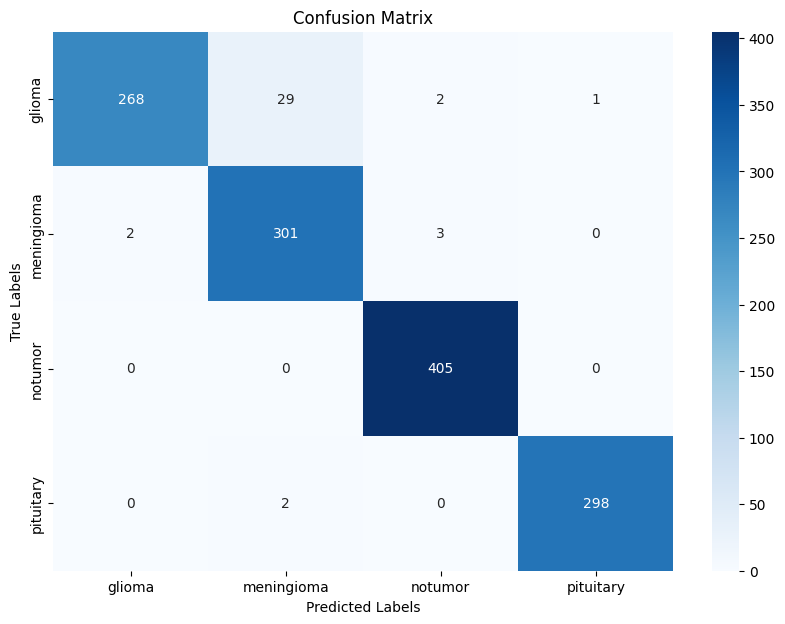

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the labels of the test set using the trained SVM
test_predictions = svm_model.predict(test_features_pca)

# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_names, yticklabels=test_data.class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

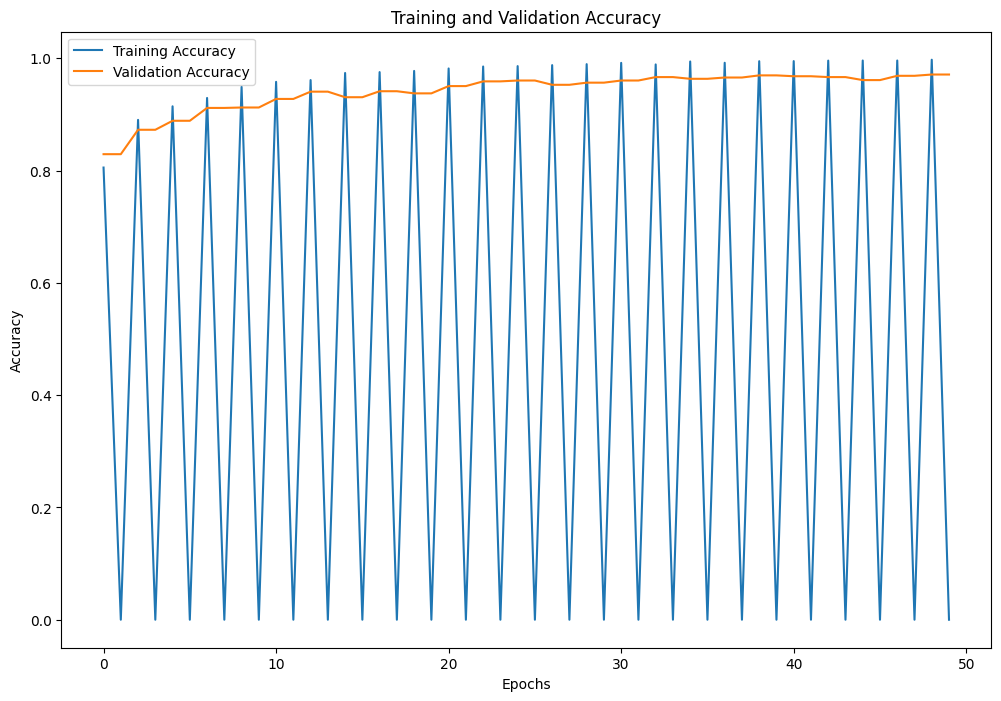

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Graph

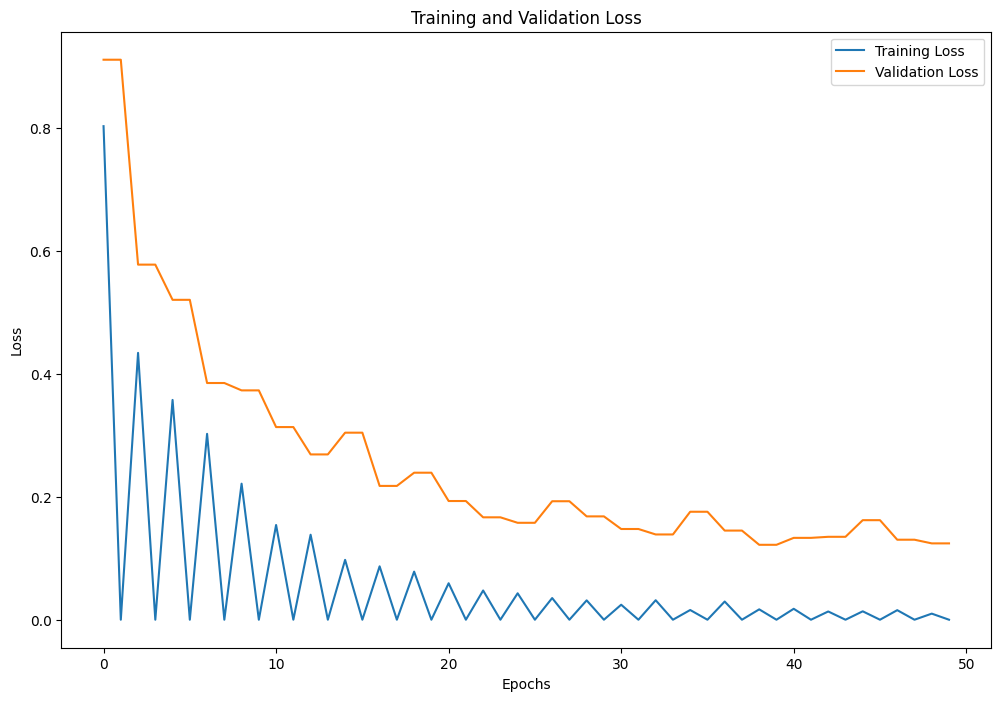

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()